# The `ImageROI` class

The purpose of the `ImageROI` class is to provide an interface for setting the positions of punch-holes and to do some basic light-dark classification.

## Initialization
`ImageROI` is intended to be called downstream of `ImageSample`, either by providing the `ImageSample` instance directly or the image. In rare cases, it may not be desired to initialize an `ImageSample` instance, for example, if you are certain that the image you provide already is the sample region. In this case, you can provide either the image (pay attention to the correct type, the type depends on how you load the image) or a file path:

```python
from msi_workflow import ImageROI

roi = ImageROI(path_image_file=r'your\path\image_file.png')
```
or
```python
import numpy as np
from msi_workflow import ImageROI

img = np.random.random((100, 100))
roi = ImageROI(image=img, image_type='np')
```

And finally, let's cover the option of providing the `ImageSample` instance. Assuming that you followed the previous chapter, you can use your saved instance:

In [1]:
from maspim import ImageSample, ImageROI
import user_params

%matplotlib inline

path_folder = user_params.path_folder_test_data

sample = ImageSample.from_disk(path_folder)
roi = ImageROI.from_parent(sample)

print(roi)

obj_color: light
_hw: [4647, 13452]
_image: Numpy array of type uint8, with shape (4647, 13452, 3)
path_folder: C:\Users\Yannick Zander\Promotion\Test data
age_span: None


Again the most convenient way is to use a `Project` instance. 

In [2]:
from maspim import get_project

project = get_project(is_MSI=True, path_folder=path_folder, is_laminated=False)
project.set_image_roi()

No age span specified, falling back to more general method
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.83it/s]


You can see a warning that the age span is not specified. This is because the `Project` class immediately executes all steps, but let's examine those steps in a bit more detail

## Classifying the image

For this section, we will use an image that shows some lamination (the *'test_image.tif'* file inside the *Data* folder)

In this step, the image is divided up into background, light, and dark pixels. Background pixels are inherited from the `ImageSample` object, if possible. Otherwise, the Otsu filter is called on the input image. Let's check out what that looks like

In [3]:
path_image_file = r'Data\test_image.tif'

laminated = ImageSample(path_image_file=path_image_file)
laminated_roi = ImageROI.from_parent(laminated)

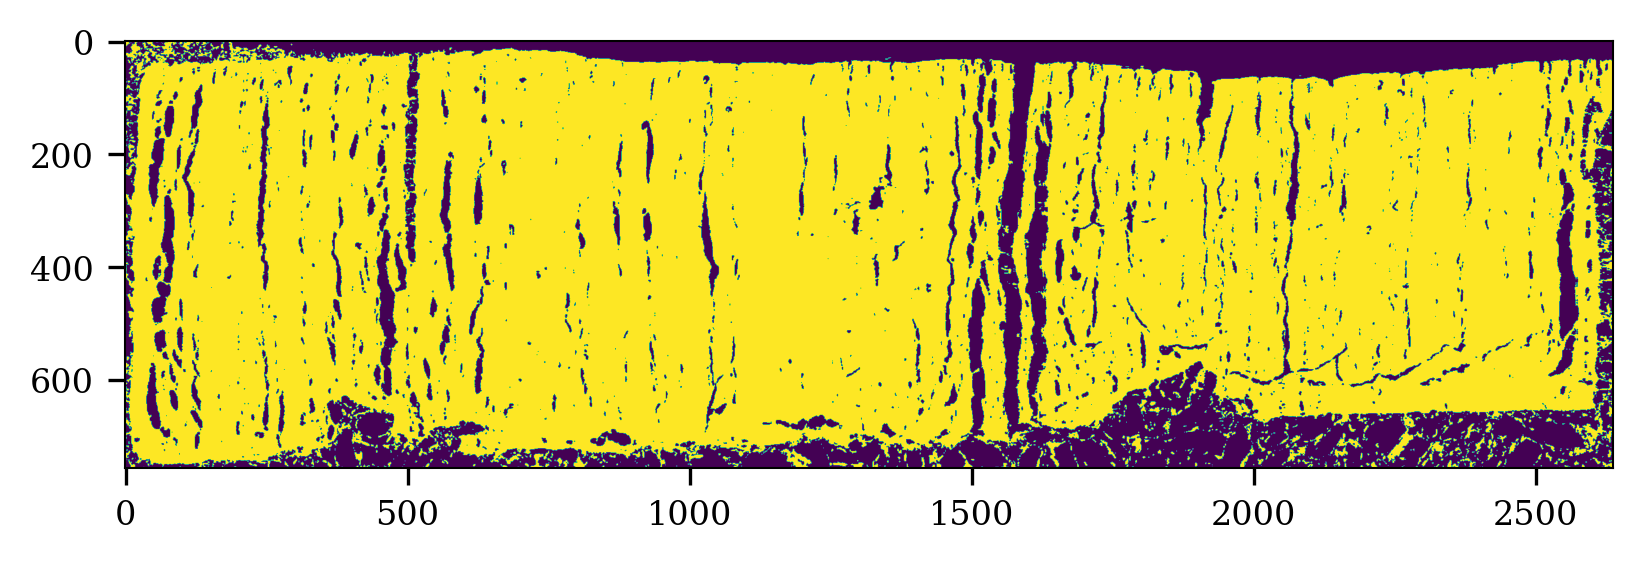

In [4]:
import matplotlib.pyplot as plt
plt.imshow(laminated_roi.mask_foreground)
plt.show()

You can see that the foreground pixels were mostly corrected identified. 

Oftentimes it is interesting to consider light and dark areas separately as they may represent different deposition regimes (e.g. seasons). Identifying those areas is less trivial than it may appear at first glance since we only care about areas that have actually different sediment colors and are not merely influenced by lighting differences.

One option is to consider all scales and take the median classification. This method in general is more vulnerable against holes (especially since the sample tends to thin out towards holes) and if an age model exists, the adaptive mean method is preferential

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.90it/s]


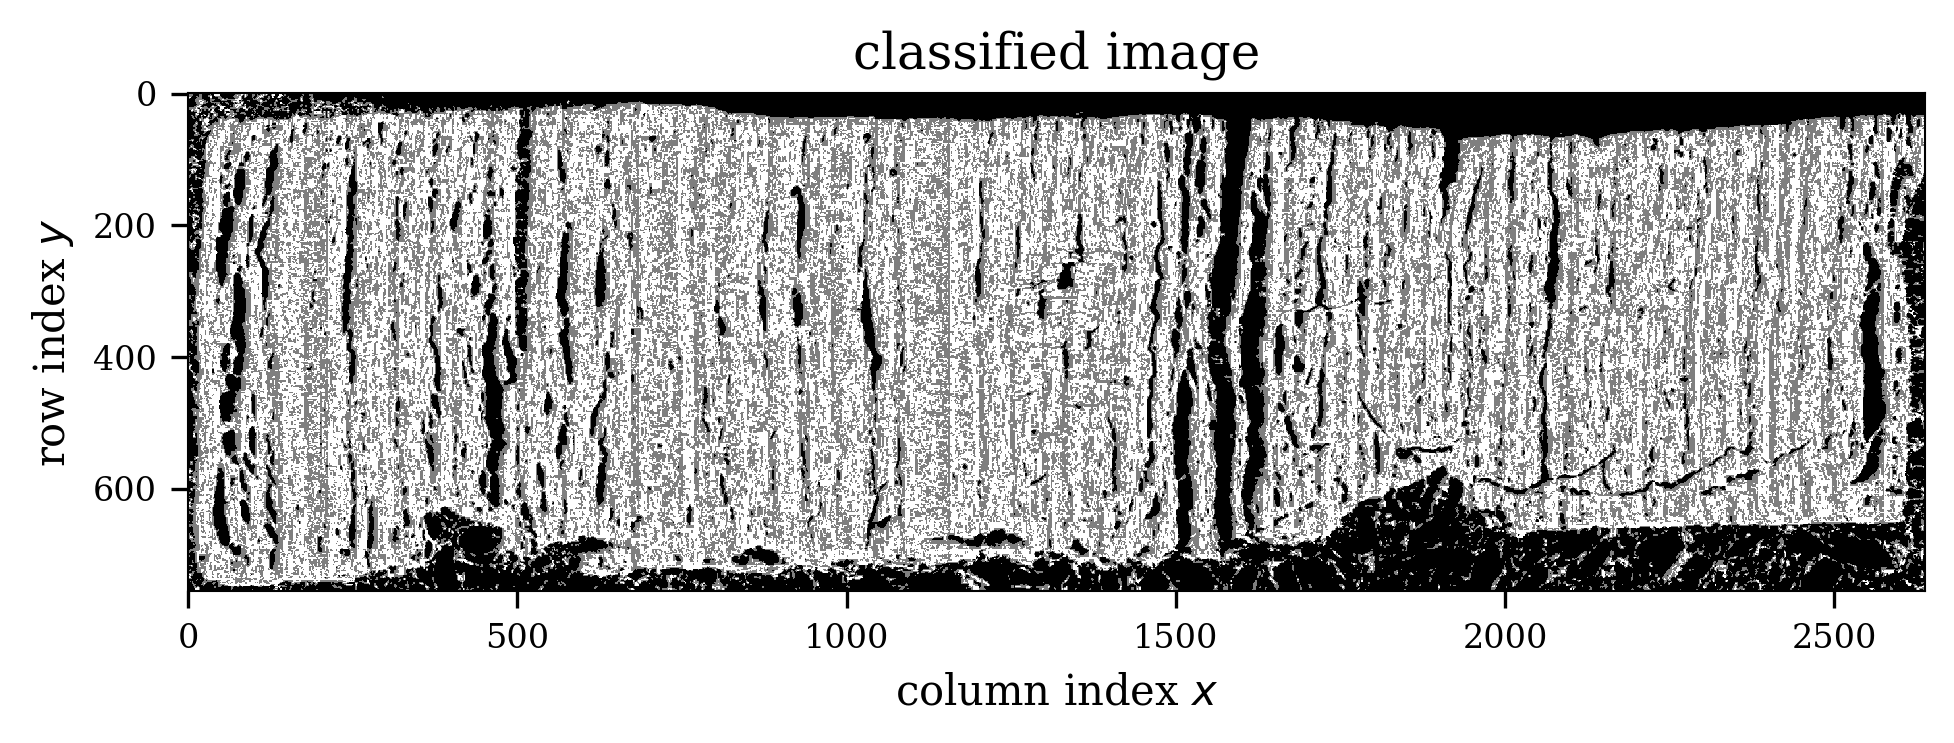

In [5]:
laminated_roi.set_classification_varying_kernel_size(plts=True)

The way to go here is to use local filters that essentially take the average or median intensity in an area around a pixel. The critical parameter here is the kernel size. Too large and you are not getting rid of lighting effects. Too small, and you overattenuate noise. If an age model is present, you can set the age span. The number of expected cycles will be calculated automatically and the kernel size set accordingly (assuming a constant sedimentation rate, the window would cover two cycles)

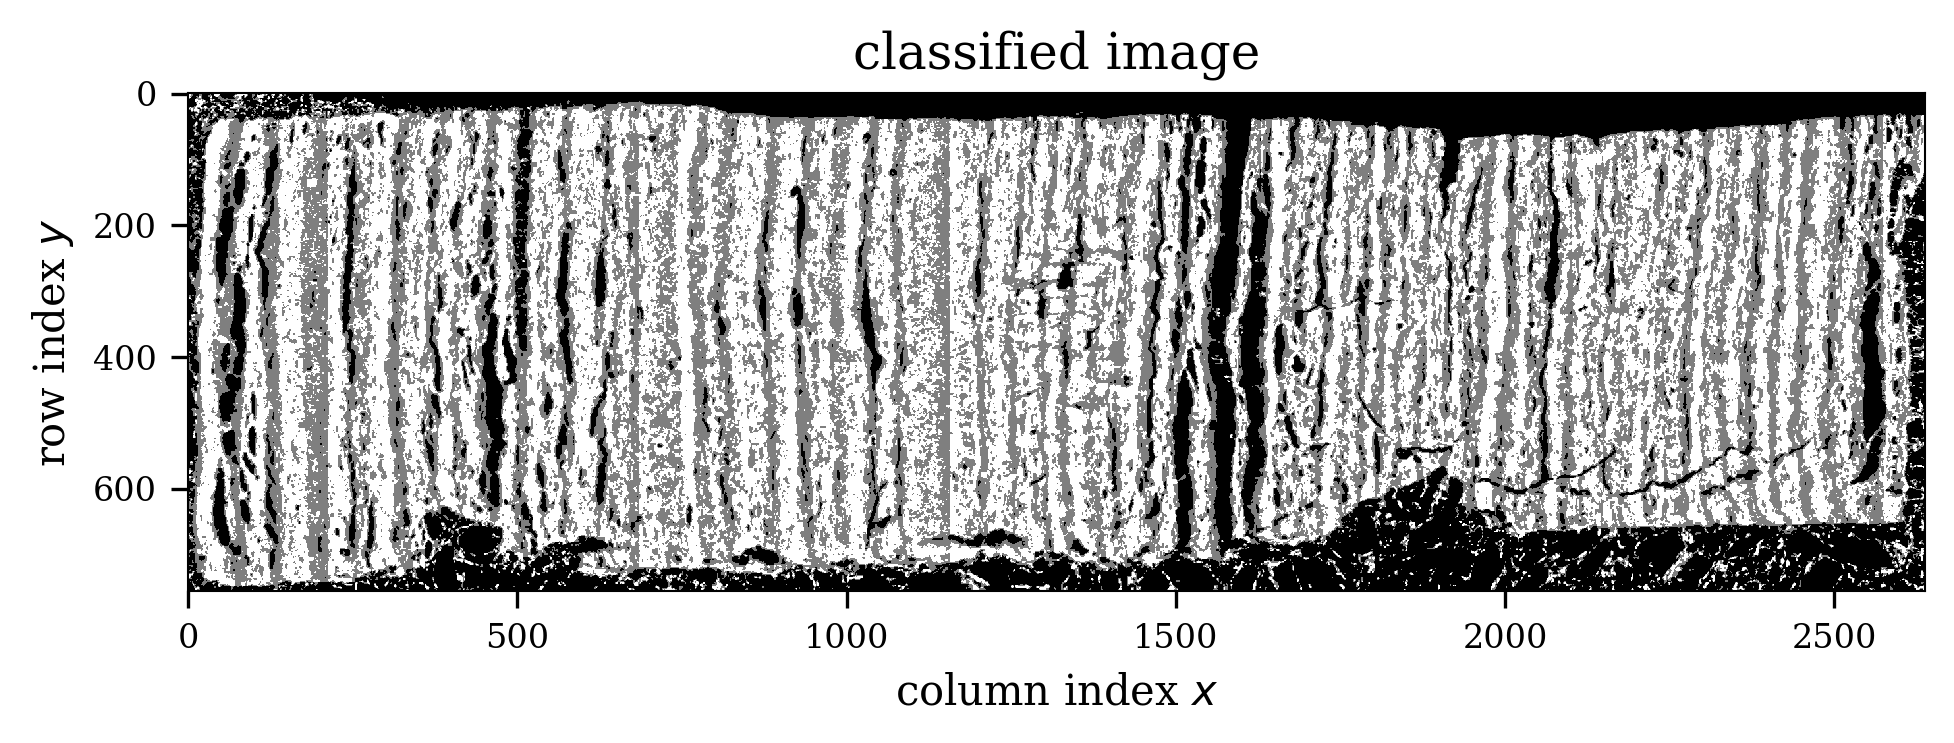

In [6]:
# age span of 100 years is roughly correct
laminated_roi.age_span = (0, 100)
laminated_roi.set_classification_adaptive_mean(plts=True)

## Punch hole detection

The next step would be to identify punch holes. They can be used to map the photo and other measurements (e.g. X-Ray) on top of each other. This step is not always required because other methods may be more suitable. For example, for the previous measurement, we would recommend using the bounding box since it is hard to locate the original positions of the punch holes. Nevertheless, this is what the function call would look like (setting *interactive=True* would open a separate window for you to specify the punch holes manually). In case you are curious: the algorithm looks for areas that are square-shaped by convolving the image with a kernel that has positive weights in the center and lower weights at diagonal pixels. You can see that in the plots below, the dark blue colors represent negative weights. Punch holes are defined as the lowest (or highest value if the sample is *'dark'*) value in the left and right half of the image. We run the algorithm once on the lower and once on the upper half and determine the side with the punch holes as the one that achieves better scores. For this example, they end up at the bottom, as they should. You can provide *side='bottom'* if you know this before calling the method (e.g. because for all measurements the punch holes are at the bottom.

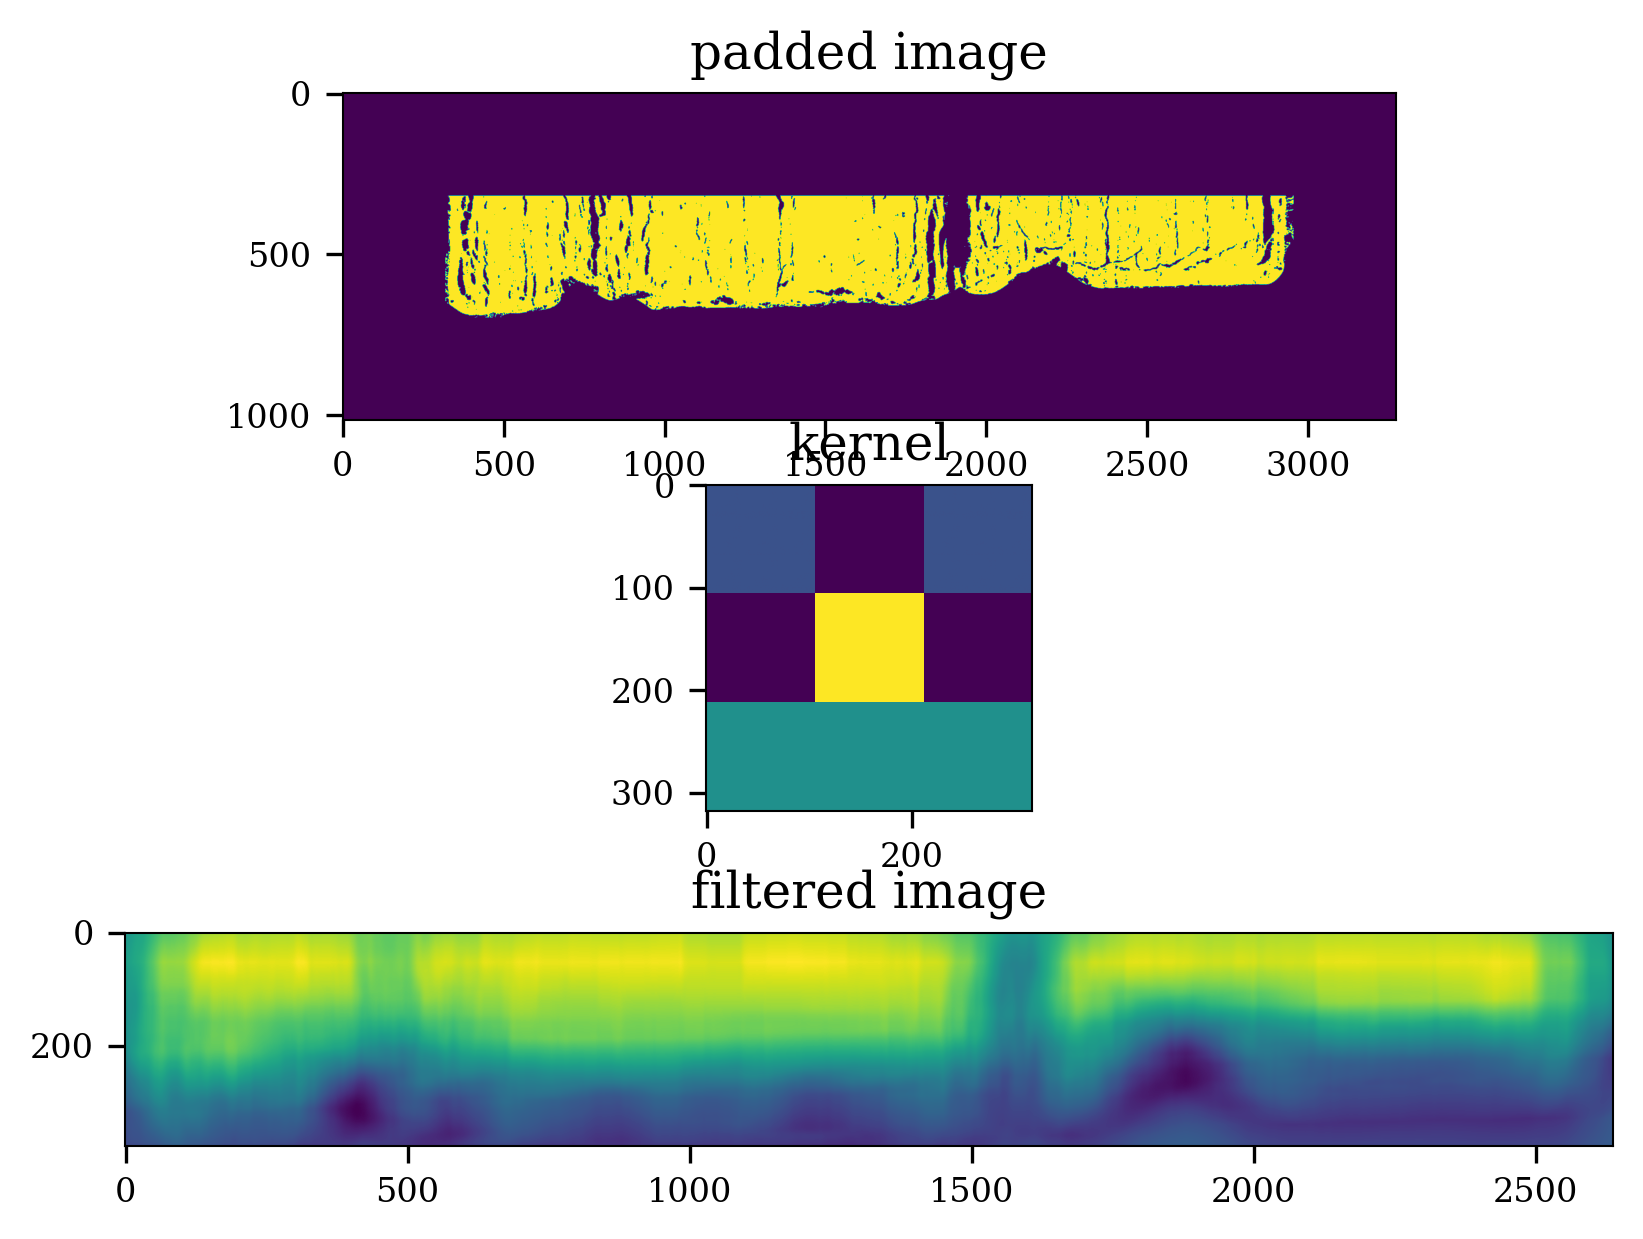

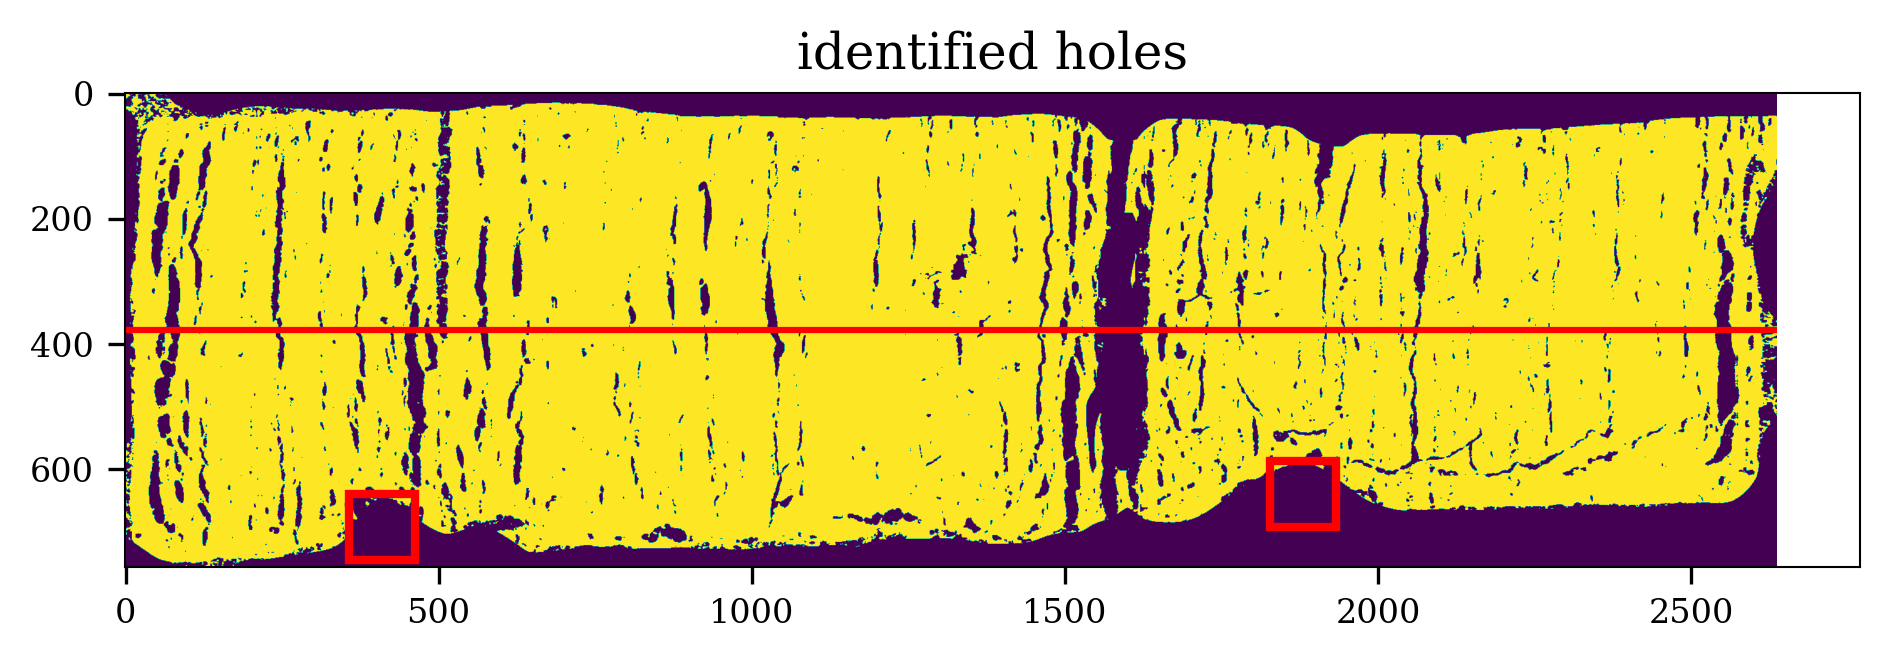

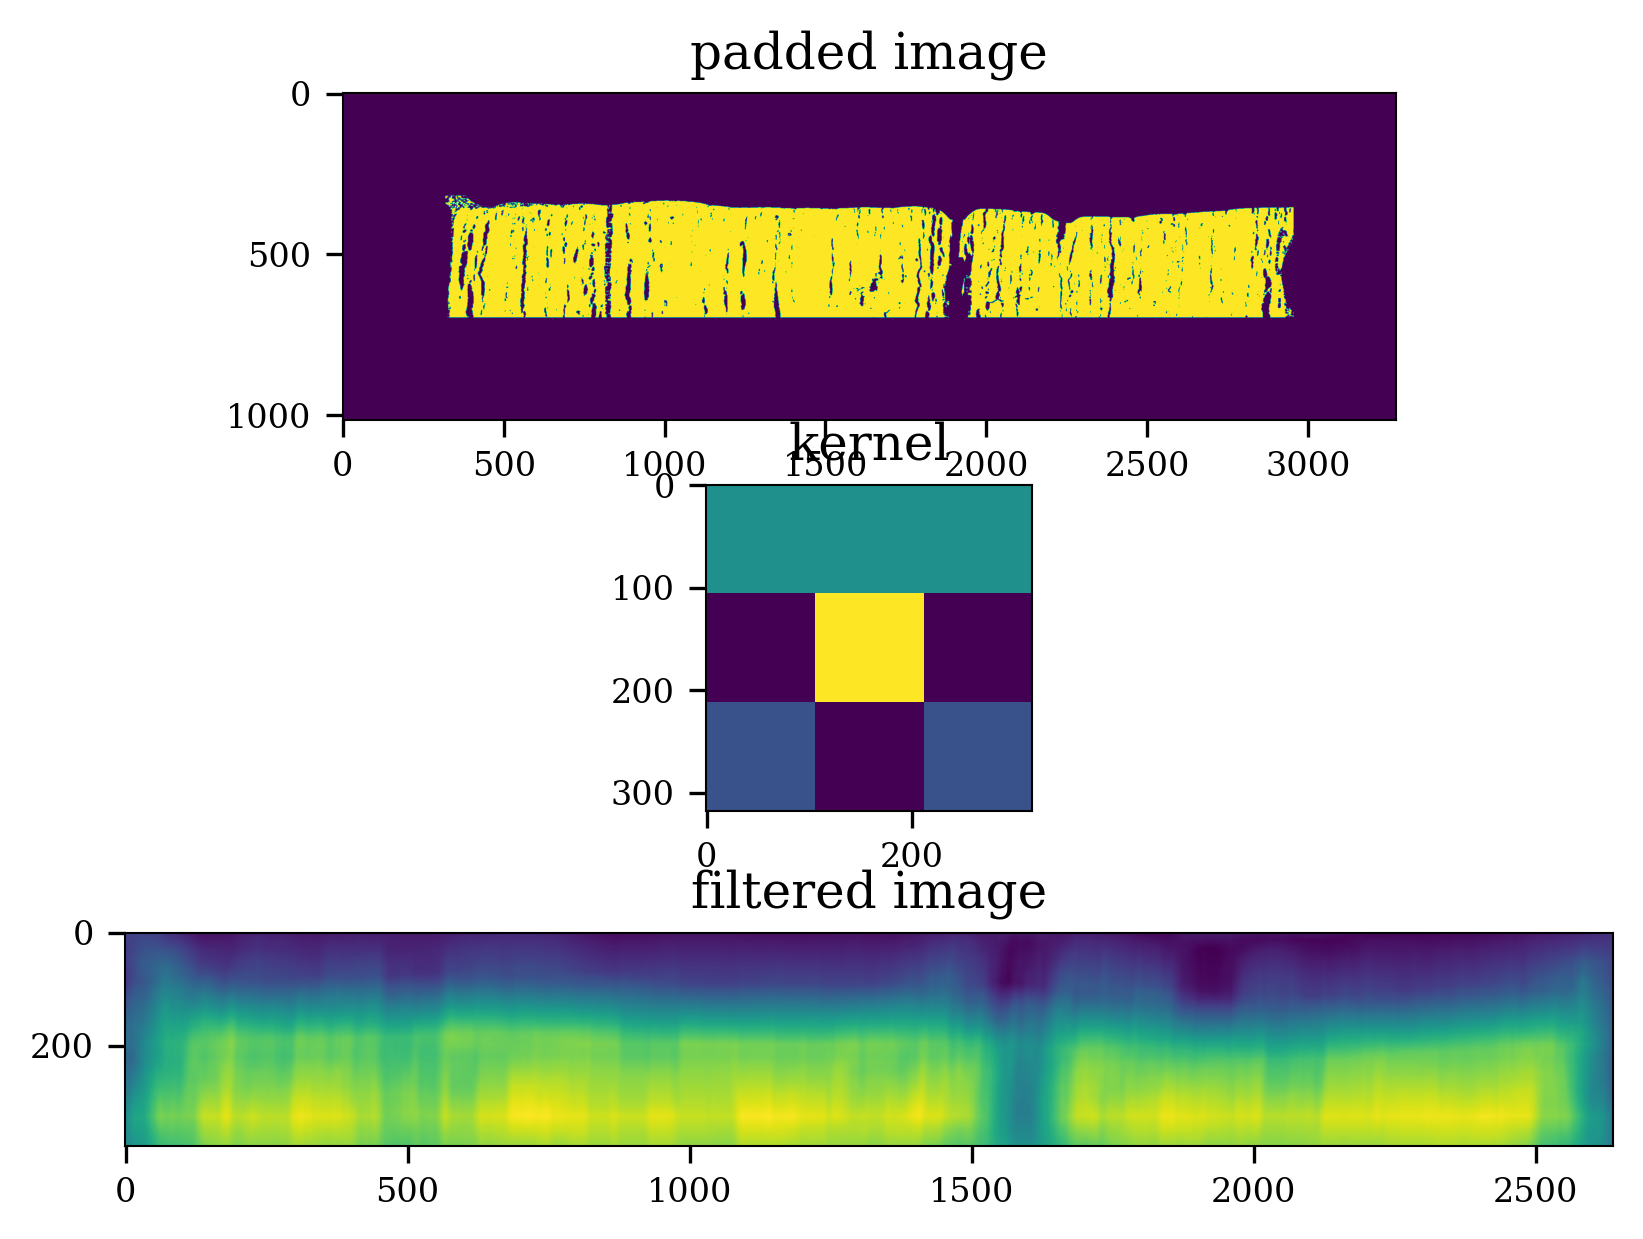

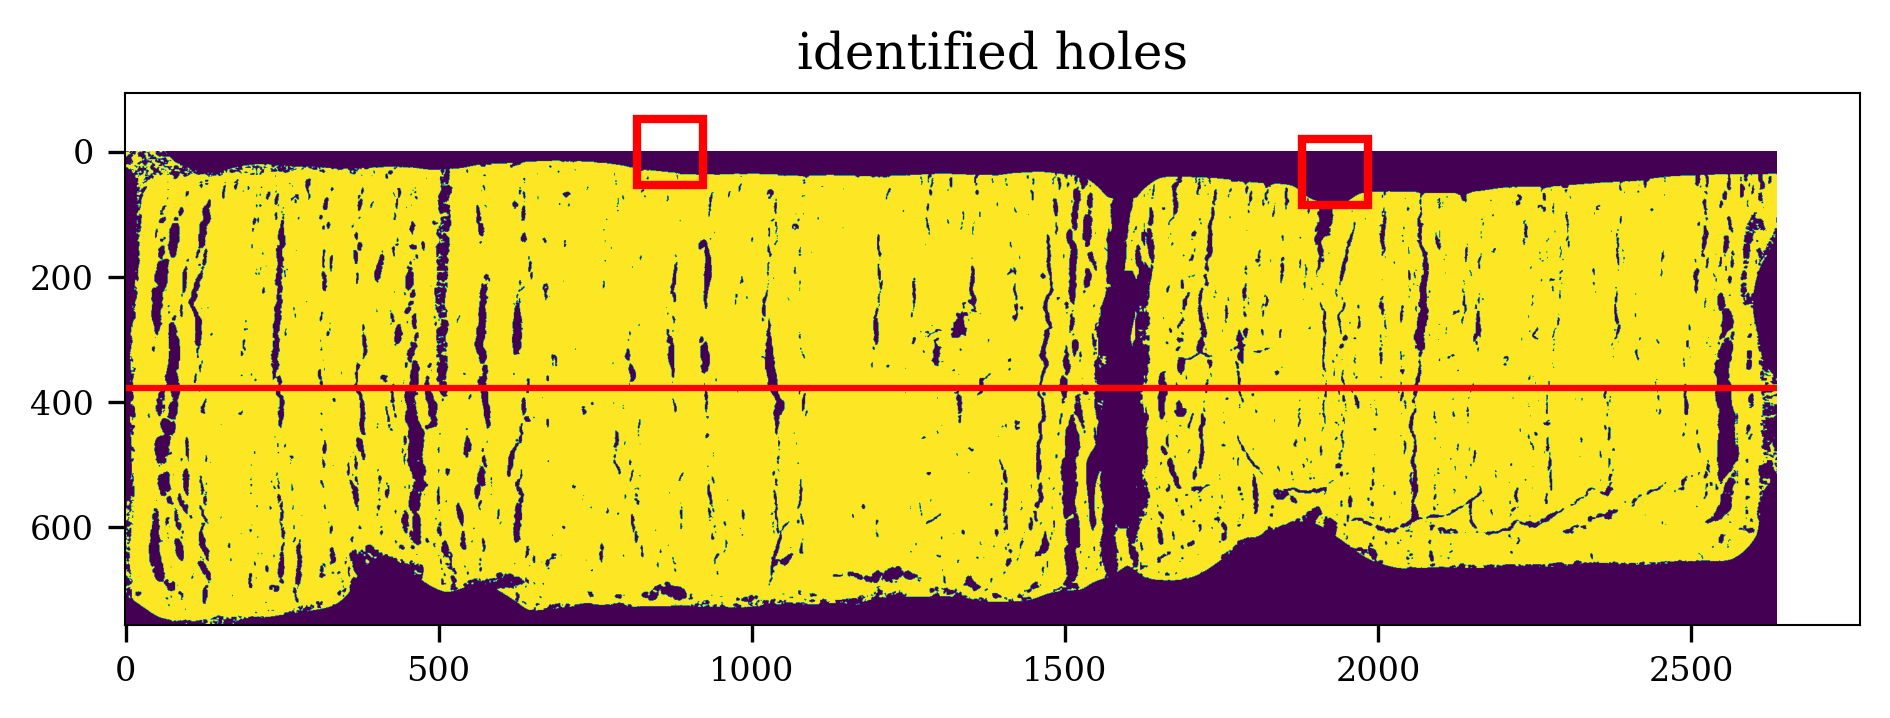

In [7]:
laminated_roi.set_punchholes(interactive=False, plts=True)

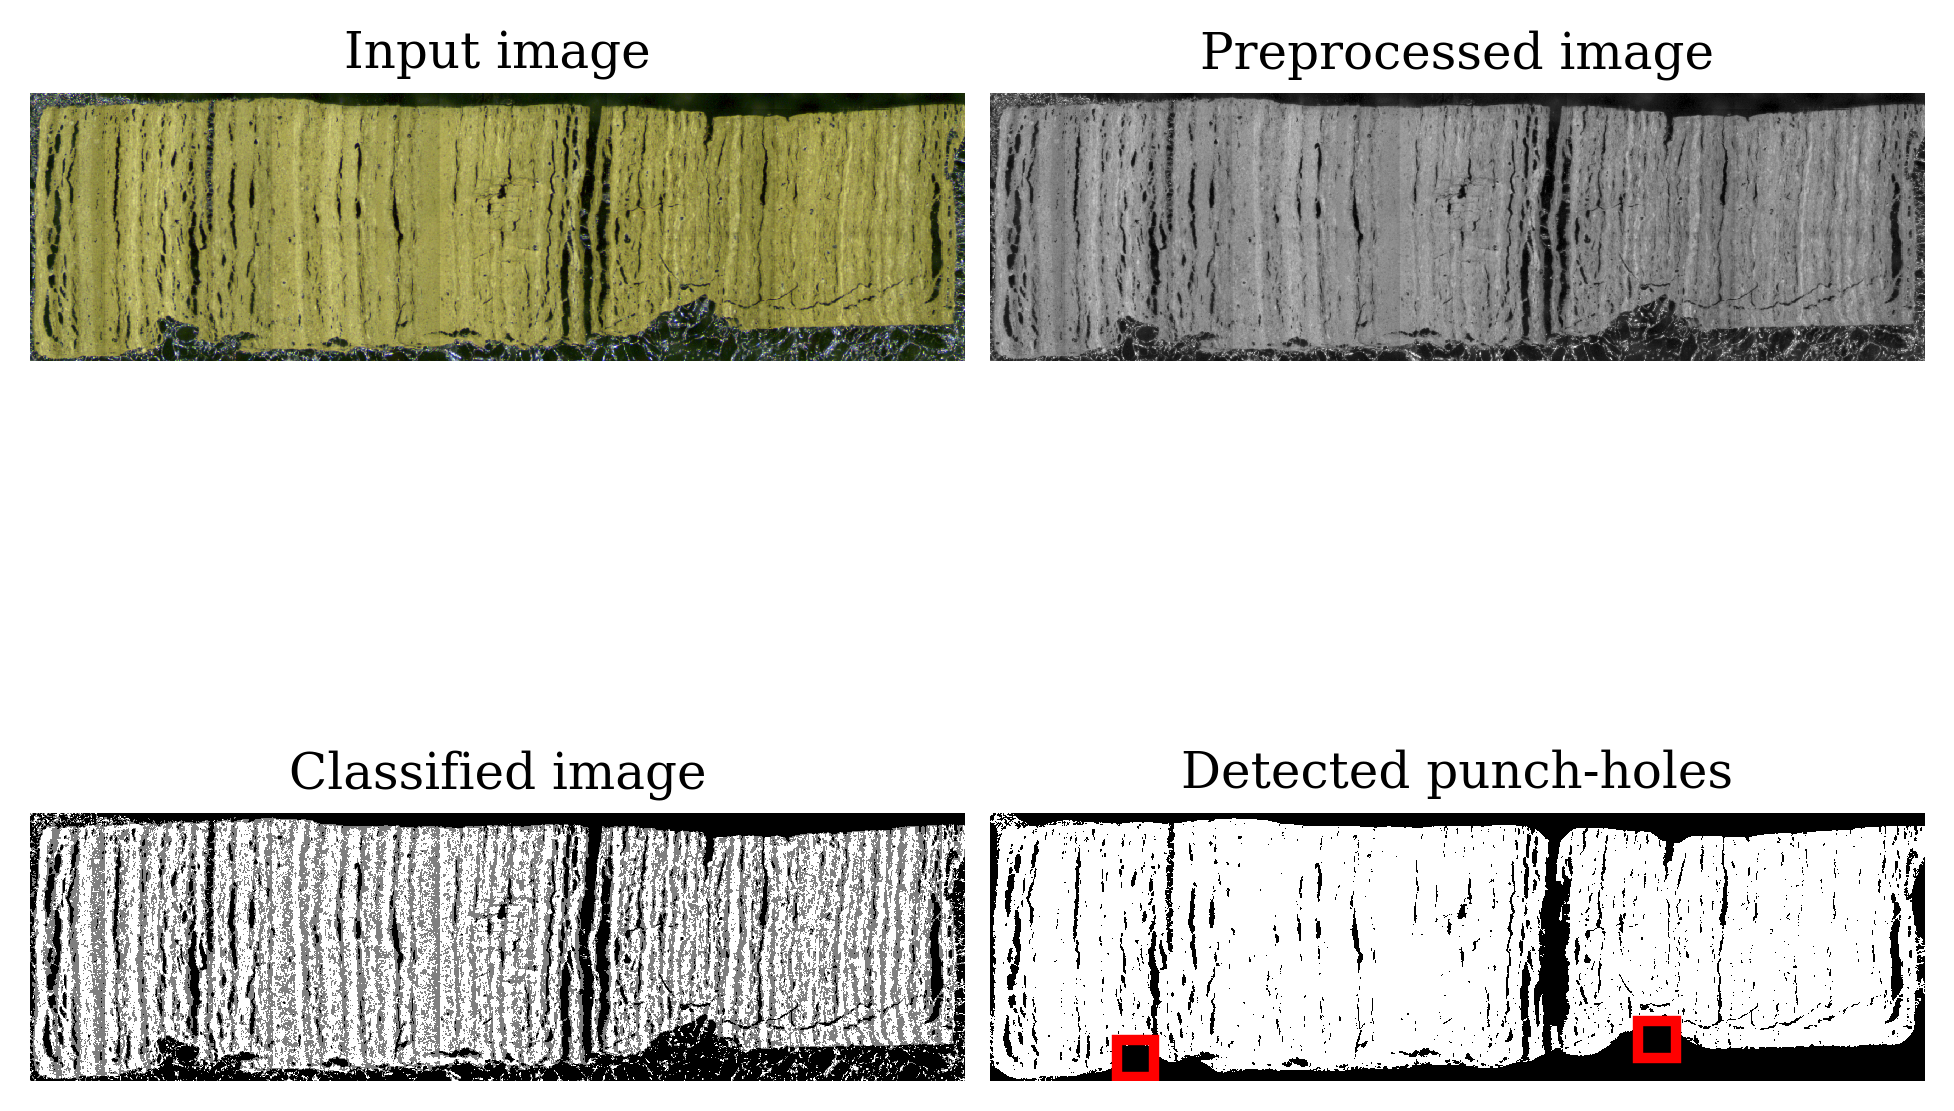

In [8]:
laminated_roi.plot_overview()

Let's save this so we can use it in the next section (this will create or overwrite an *'ImageROI.pickle'* file in the *Data* folder

In [9]:
laminated_roi.save()